In [55]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
import sys
import importlib
sys.path.append('/app/mtn_proj_ticks/')
import climbing_ticks_helper as helper
importlib.reload(helper)
pd.set_option('display.expand_frame_repr', False) # display full data in terminal
%matplotlib inline

# GOAL: Given an exported CSV from Mountain Project for a users ticks, make a model that will predict the number of attempts to send a route, and the send style (onsight, flash, redpoint, etc.) including multi-pitch routes

In [56]:
def initial_data_cleaning(df):
    # separate safety rating from main rating (PG13, R, X)
    df['Safety'] = df['Rating'].str.extract(r'(PG13|R|X)', expand=False)
    df['Safety'] = df['Safety'].fillna('G')
    df['Rating'] = df['Rating'].str.replace(r' (PG13|R|X)', '', regex=True)

    # separate out 'Alpine' from the 'Style' column
    df['Alpine'] = df['Route Type'].str.contains(r'Alpine').astype(int)
    df['Route Type'] = df['Route Type'].str.replace(r', Alpine', '', regex=True)

    # replace pinkpoint with redpoint
    df['Lead Style'] = df['Lead Style'].replace('Pinkpoint', 'Redpoint')

    # Get RouteID from URL
    df['RouteID'] = df['URL'].apply(lambda x: x.split('/')[-2])

    # Reorder columns and drop unnecessary columns
    df = df[['RouteID', 'Route', 'Date', 'Route Type', 'Alpine', 'Rating', 'Safety', 'Avg Stars', 'Pitches', 'Location', 'Style', 'Lead Style']]

    # Organize Route Type entries TODO: figure out how many of these I removed
    route_type_mapping = {'Sport, TR': 'Sport', 'Trad, TR': 'Trad', 'Trad, Sport': 'Trad', 'TR, Boulder': 'Boulder'}
    df['Route Type'] = df['Route Type'].replace(route_type_mapping)

    return df

def remove_unusalbe_data(df):
    # remove obscure and uncommon route types
    remove_route_types = ["TR", "Trad, Aid", "Sport, Aid", "Sport, Aid, Boulder, Mixed", "Trad, Sport, TR", "Trad, TR, Boulder", "Trad, TR, Aid", "TR, Boulder, Alpine", "Trad, Boulder"]
    df = df[~df['Route Type'].isin(remove_route_types)]
    
    # remove anything in Generic Area (too difficult to parse out different routes) # TODO: figure out how many of these I removed
    df = df[~df['Location'].str.contains('Generic Area')]

    # A bit dirty, but replace Topropes with Fell/Hung to better capture redpoint attempts, but this also skews routes that I TR'd once cleanly and never lead... :/
    # df.loc[df['Style'] == 'Toprope', 'Lead Style'] = 'Fell/Hung'
    # df.loc[df['Style'] == 'Toprope', 'Style'] = 'Lead'

    # only lookig at Lead routes for now, and drop anything without a lead style
    df = df[df['Style'] == 'Lead']
    df = df.dropna(subset=['Style', 'Lead Style'])
    df = df.drop(columns=['Style'])
    
    # drop boulders (may be redundant with the route type removal)
    df = df[df['Route Type'] != 'Boulder']

    # set up a column for attempts
    df['Attempts'] = 1
    return df

df_raw = pd.read_csv("/app/ticks.csv")
df = initial_data_cleaning(df_raw.copy())
df = remove_unusalbe_data(df)
df.head()

# TODO:
# df_boulder = df[df['Route Type'] == 'Boulder'] # Analyze Boulder routes separately later
# * either delete Location, or figure out a better way to organize it.
# Does a TR lap count as an attempt? eg: scarface.... :\



,RouteID,Route,Date,Route Type,Alpine,Rating,Safety,Avg Stars,Pitches,Location,Lead Style,Attempts
0,108695777,Unknown,2024-12-23,Sport,0,5.10c/d,G,2.7,1,Colorado > Canon City > Shelf Road > Sand Gulc...,Onsight,1
1,105749980,Cyborg,2024-12-23,Sport,0,5.11b,G,2.5,1,Colorado > Canon City > Shelf Road > Sand Gulc...,Onsight,1
2,126571538,Lucky Lettuce,2024-12-23,Sport,0,5.9,G,2.3,1,Colorado > Canon City > Shelf Road > Sand Gulc...,Onsight,1
3,112557064,Scary Carrie,2024-12-23,Sport,0,5.10a/b,G,2.8,1,Colorado > Canon City > Shelf Road > Sand Gulc...,Onsight,1
4,105749119,The Apple Bites Back,2024-12-23,Sport,0,5.11c,G,3.5,1,Colorado > Canon City > Shelf Road > Sand Gulc...,Onsight,1


In [57]:
# This cell is not the cleanest code at the moment

def cleanup_multipitch_routes(df):
    ''' a 2 pitch Onsight Row, means it is a 2pitch route, 1 attempt
        a 2 pitch Flash row means it is a 2 pitch route, 1 attempt
        a 2 pitch Redpoint row, means it was a 1 pitch route with 2 attempts, 1 Fell/Hung, and 1 Redpoint.
        a 2 pitch Fell/Hung row, means it was a 1 pitch route with 2 attempts, each a Fell/Hung
        if 'Route Type' == trad, in rmp & fmp, that mean means pitches remains uncahnged, and attempts = 1
        if 'Route Type' == sport, in rmp/fmp, set attempts = pitches, and pitches = 1.
    '''
    mprfhs = df[(df['Pitches'] > 1) & 
                    (df['Lead Style'].isin(['Redpoint', 'Fell/Hung'])) & 
                    (df['Route Type'] == 'Sport') &
                    (~df['Route'].isin(['The Richness of It All', 'Lost in Space', 'Not One Of Us']))]
    mprfhs.loc[:, 'Attempts'] = mprfhs['Pitches']
    mprfhs.loc[:, 'Pitches'] = 1

    # apply the changes to the trimmed dataframe
    df.loc[mprfhs.index, 'Attempts'] = mprfhs['Attempts']
    df.loc[mprfhs.index, 'Pitches'] = mprfhs['Pitches']
    return df

def group_by_route(df):
    # combine Lead Style rows with "Onsight" or "Flash" to a single value of "Onsight/Flash"
    df['Lead Style'] = df['Lead Style'].replace(['Onsight', 'Flash'], 'Onsight/Flash')

    # Convert the Lead Style column to a categorical type with the specified order (OS/Flash, Redpoint, Fell/Hung)
    df['Lead Style'] = pd.Categorical(df['Lead Style'], categories=helper.lead_style_order(), ordered=True)

    # step 2. combine rows with the same RouteID
    df = df.groupby('RouteID').agg({'Route': 'first',      'Date': 'last', 'Location': 'first',
                                    'Route Type': 'first', 'Alpine': 'first',
                                    'Rating': 'first',     'Safety': 'first',
                                    'Avg Stars': 'first',  'Pitches': 'max',
                                    'Lead Style': 'max',   'Attempts': 'sum'}).reset_index()

    # remove one attempt from Meltdown (110629043) becuase one of my ticks was only a single pitch
    df.loc[df['RouteID'] == '110629043', 'Attempts'] = 1
    return df

df_cleaned = cleanup_multipitch_routes(df)
df_grouped = group_by_route(df_cleaned)
df_grouped.to_csv('/app/grouped_ticks.csv', index=False) # save for reference
oe = OrdinalEncoder(mapping=helper.ordinal_mapping(df))
df_ordinal = oe.fit_transform(df_grouped)


/usr/local/lib/python3.13/site-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


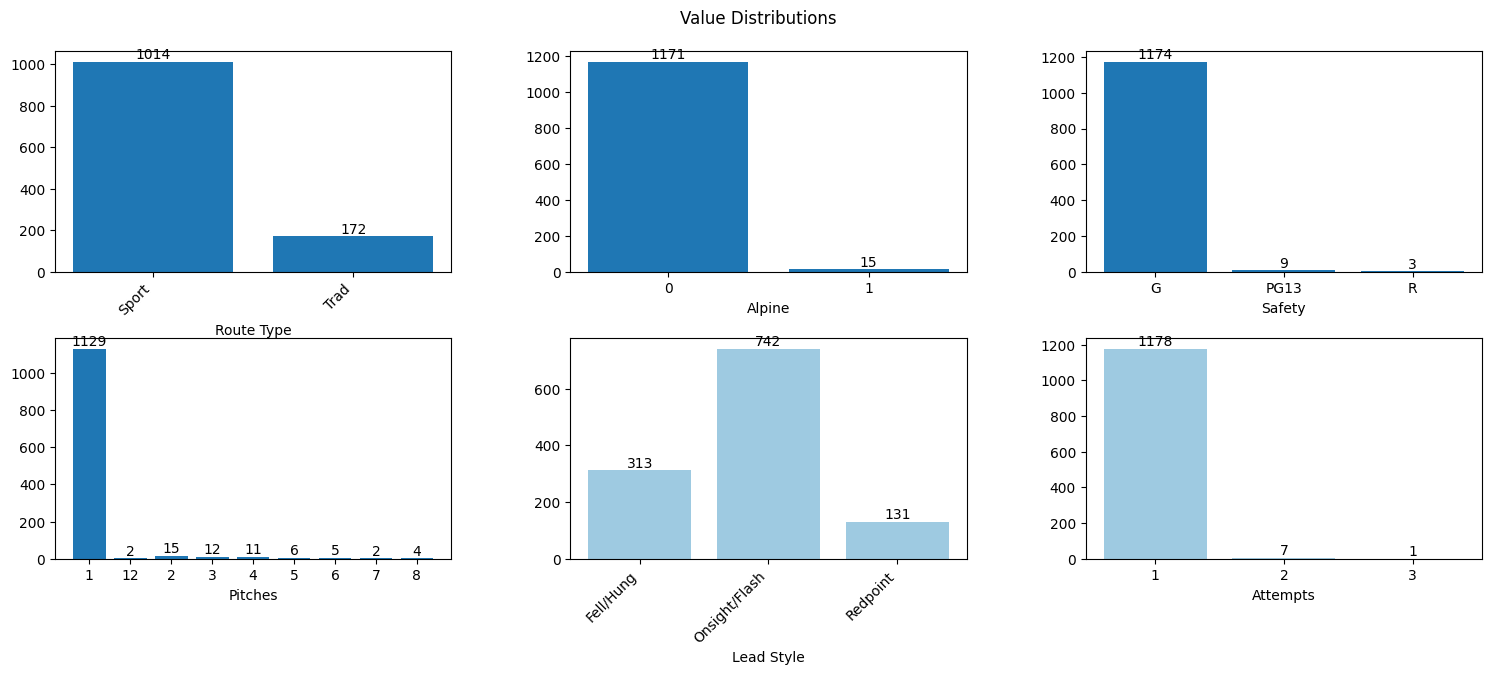

In [58]:
# plot value counts
def setup_plot():
    fig, ax = plt.subplots(2,3, figsize=(15,6))
    ax = ax.flatten()
    fig.suptitle("Value Distributions")
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    return fig, ax

def plot_value_counts(data, column, ax):
    vc = data[column].dropna().astype(str).value_counts().sort_index()
    ax.set_xlabel(column)

    # Set color for Survived column
    # fix line below with notin method
    color = '#1f77b4' if column not in ['Lead Style', 'Attempts'] else '#9ecae1'
    bars = ax.bar(range(len(vc)), vc.values, color=color)
    
    # Set x-tick labels
    ax.set_xticks(range(len(vc)))
    ax.set_xticklabels(vc.index)
    
    # Rotate labels for specific columns or if there are many categories
    if column in ['Route Type', 'Lead Style']:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
        
columns_to_plot = ['Route Type', 'Alpine', 'Safety', 'Pitches', 'Lead Style', 'Attempts']
# uncommend below to plot

fix, ax = setup_plot()
for i, col in enumerate(columns_to_plot):
    plot_value_counts(df, col, ax[i])

In [59]:
# route, routeID, and Location have been useful for looking at data, but now are not needed for the model
df_model_ready = df_ordinal.copy()
df_model_ready.drop(columns=['Route', 'Location'], inplace=True)
# save df_model_ready to csv using RouteID as the index
df_model_ready.set_index('RouteID', inplace=True)
df_model_ready.to_csv('/app/model_ready_ticks.csv')

In [60]:
# the model needs some more knowledge, like it shuldn't predict a Flash or Onsight along with more than 1 attempt, and it should predict a Redpoint with at least 2 attempts.